**SETUP AND IMPORTS**

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import string
import re
import joblib
import json
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import os

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dense, Flatten, Conv1D, MaxPooling1D, SimpleRNN, GRU, LSTM, LSTM, Input, Embedding, TimeDistributed, Flatten, Dropout,Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**DATA LOADING AND DATASET CREATION**

In [2]:
import kagglehub
path = kagglehub.dataset_download("elvis23/mental-health-conversational-data")

path_to_json = 'mentalhealth.json'
with open(path_to_json) as file:
    data = json.load(file)

100%|██████████| 11.8k/11.8k [00:00<00:00, 13.0MB/s]

Extracting files...


In [10]:
def frame_data(feat_1,feat_2,is_pattern, data):
  is_pattern = is_pattern
  df = pd.DataFrame(columns=[feat_1,feat_2])

  for intent in data['intents']:
    if is_pattern:
      for pattern in intent['patterns']:
        w = pattern
        data_to_append = {feat_1:w, feat_2:intent['tag']}
        df.loc[len(df)] = data_to_append

    else:
      for response in intent['responses']:
        w = response
        data_to_append = {feat_1:w, feat_2:intent['tag']}
        df.loc[len(df)] = data_to_append
  return df

In [11]:
df1 = frame_data('questions','labels',True, data)

In [12]:
df1.labels.value_counts(sort=False)

,count
labels,
greeting,12
morning,1
afternoon,1
evening,1
night,1
...,...
fact-28,1
fact-29,1
fact-30,1


In [13]:
df2 = frame_data('response','labels',False, data)

In [14]:
df1.head()

,questions,labels
0,Hi,greeting
1,Hey,greeting
2,Is anyone there?,greeting
3,Hi there,greeting
4,Hello,greeting


In [20]:
path_to_dumps = '/content/'
if not os.path.exists(path_to_dumps):
    os.makedirs(path_to_dumps)

In [15]:
df2.head()

,response,labels
0,Hello there. Tell me how are you feeling today?,greeting
1,Hi there. What brings you here today?,greeting
2,Hi there. How are you feeling today?,greeting
3,Great to see you. How do you feel currently?,greeting
4,Hello there. Glad to see you're back. What's g...,greeting


In [16]:
lemmatizer = WordNetLemmatizer()

vocab = Counter()
labels = []
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

def remove_stop_words(tokenizer,df,feature):
    doc_without_stopwords = []
    for entry in df[feature]:
        tokens = tokenizer(entry)
        joblib.dump(tokens,path_to_dumps+'tokens.pkl')
        doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return

In [21]:
def create_vocab(tokenizer,df,feature):
    for entry in df[feature]:
        tokens = tokenizer(entry)
        vocab.update(tokens)
    joblib.dump(vocab, path_to_dumps+'vocab.pkl')
    return
create_vocab(tokenizer,df1,'questions')
vocab

Counter({'hi': 6,
         'hey': 6,
         'is': 39,
         'anyone': 6,
         'there': 15,
         'hello': 3,
         'howdy': 3,
         'hola': 3,
         'bonjour': 3,
         'konnichiwa': 3,
         'guten': 3,
         'tag': 3,
         'ola': 3,
         'good': 15,
         'morning': 3,
         'afternoon': 3,
         'evening': 3,
         'night': 3,
         'bye': 9,
         'see': 6,
         'you': 114,
         'later': 3,
         'goodbye': 3,
         'au': 3,
         'revoir': 3,
         'sayonara': 3,
         'ok': 12,
         'then': 3,
         'fare': 3,
         'thee': 3,
         'well': 6,
         'thanks': 6,
         'thank': 9,
         'thats': 9,
         'helpful': 3,
         'for': 30,
         'the': 30,
         'help': 18,
         'than': 3,
         'very': 9,
         'much': 12,
         'nothing': 9,
         'who': 18,
         'are': 45,
         'what': 87,
         'tell': 18,
         'me': 57,
         'more': 1

In [22]:
vocab_size = len(vocab)
vocab_size

294

In [23]:
df1.groupby(by='labels',as_index=False).first()['questions']

,questions
0,Who are you?
1,Good afternoon
2,I feel so anxious.
3,Can I ask you something?
4,Oh I see.
...,...
75,I want some advice.
76,yeah you're right. i deserve a break.
77,i did what you said and i feel alot better. th...
78,I feel so worthless.


In [24]:
test_list = list(df1.groupby(by='labels',as_index=False).first()['questions'])
test_list

['Who are you?',
 'Good afternoon',
 'I feel so anxious.',
 'Can I ask you something?',
 'Oh I see.',
 'Who created you?',
 'My mom died',
 'exams',
 "I can't take it anymore",
 "That's all.",
 'Good evening',
 'What is mental health?',
 'What causes mental illness?',
 'What are some of the warning signs of mental illness?',
 'Can people with mental illness recover?',
 'What should I do if I know someone who appears to have the symptoms of a mental disorder?',
 'How can I find a mental health professional for myself or my child?',
 'What treatment options are available?',
 'If I become involved in treatment, what do I need to know?',
 'What is the difference between mental health professionals?',
 'How can I find a mental health professional right for my child or myself?',
 'Where else can I get help?',
 'Why is mental health important?',
 'What should I know before starting a new medication?',
 'Where can I go to find therapy?',
 'Where can I learn about types of mental health treatme

In [25]:
test_index = []
for i,_ in enumerate(test_list):
    idx = df1[df1.questions == test_list[i]].index[0]
    test_index.append(idx)
test_index

[np.int64(31),
 np.int64(13),
 np.int64(93),
 np.int64(166),
 np.int64(82),
 np.int64(40),
 np.int64(109),
 np.int64(137),
 np.int64(71),
 np.int64(121),
 np.int64(14),
 np.int64(190),
 np.int64(207),
 np.int64(208),
 np.int64(209),
 np.int64(210),
 np.int64(211),
 np.int64(212),
 np.int64(213),
 np.int64(214),
 np.int64(215),
 np.int64(216),
 np.int64(192),
 np.int64(217),
 np.int64(218),
 np.int64(219),
 np.int64(220),
 np.int64(221),
 np.int64(222),
 np.int64(223),
 np.int64(225),
 np.int64(226),
 np.int64(227),
 np.int64(194),
 np.int64(228),
 np.int64(229),
 np.int64(230),
 np.int64(196),
 np.int64(200),
 np.int64(202),
 np.int64(205),
 np.int64(206),
 np.int64(165),
 np.int64(16),
 np.int64(0),
 np.int64(75),
 np.int64(134),
 np.int64(131),
 np.int64(46),
 np.int64(145),
 np.int64(185),
 np.int64(172),
 np.int64(158),
 np.int64(177),
 np.int64(188),
 np.int64(12),
 np.int64(43),
 np.int64(30),
 np.int64(15),
 np.int64(169),
 np.int64(29),
 np.int64(95),
 np.int64(181),
 np.int64(

In [26]:
train_index = [i for i in df1.index if i not in test_index]
train_index

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 25,
 26,
 27,
 28,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 41,
 42,
 44,
 45,
 47,
 48,
 49,
 50,
 51,
 52,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 62,
 63,
 64,
 65,
 67,
 68,
 69,
 70,
 72,
 73,
 74,
 76,
 77,
 78,
 79,
 80,
 81,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 94,
 96,
 97,
 98,
 100,
 101,
 102,
 103,
 104,
 106,
 107,
 108,
 110,
 111,
 112,
 113,
 114,
 116,
 117,
 118,
 119,
 120,
 122,
 123,
 124,
 125,
 127,
 128,
 129,
 130,
 132,
 133,
 135,
 136,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 146,
 148,
 149,
 151,
 152,
 153,
 155,
 156,
 157,
 159,
 160,
 162,
 163,
 164,
 168,
 170,
 171,
 173,
 174,
 176,
 178,
 180,
 183,
 184,
 186,
 187,
 189,
 191,
 193,
 195,
 197,
 198,
 199,
 201,
 203,
 204,
 224,
 231]

In [27]:
def convert_seq(df,feature):
  text = ' '.join(list(vocab.keys()))
  t = Tokenizer()
  entries = [entry for entry in df[feature]]
  print(entries)
  print('----')
  t.fit_on_texts(entries)
  joblib.dump(t, path_to_dumps+'tokenizer_t.pkl')   # why a pkl file
  vocab_size = len(t.word_index) +1 # +1 for oov
  print(t.word_index)
  entries = [entry for entry in df[feature]]
  max_length = max([len(s.split()) for s in entries])
  print('----')
  print("max length of string is : ",max_length)
  print('----')
  encoded = t.texts_to_sequences(entries)
  print(encoded)
  padded = pad_sequences(encoded, maxlen=max_length, padding='post')
  print('----')
  print(padded)
  return padded, vocab_size

In [28]:
X,vocab_size = convert_seq(df1,'questions')

['Hi', 'Hey', 'Is anyone there?', 'Hi there', 'Hello', 'Hey there', 'Howdy', 'Hola', 'Bonjour', 'Konnichiwa', 'Guten tag', 'Ola', 'Good morning', 'Good afternoon', 'Good evening', 'Good night', 'Bye', 'See you later', 'Goodbye', 'Au revoir', 'Sayonara', 'ok bye', 'Bye then', 'Fare thee well', 'Thanks', 'Thank you', "That's helpful", 'Thanks for the help', 'Than you very much', '', 'nothing much', 'Who are you?', 'What are you?', 'Who you are?', 'Tell me more about yourself.', 'What is your name?', 'What should I call you?', "What's your name?", 'Tell me about yourself', 'What can you do?', 'Who created you?', 'How were you made?', 'How were you created?', 'My name is ', 'I am name.', 'I go by ', 'Could you help me?', 'give me a hand please', 'Can you help?', 'What can you do for me?', 'I need support', 'I need help', 'Support me please', 'I am feeling lonely', 'I am so lonely', 'I feel down', 'I feel sad', 'I am sad', 'I feel so lonely', 'I feel empty', "I don't have anyone", 'I am so 

In [29]:
with open(path_to_dumps+'tokenizer_t.pkl', 'rb') as f:
    data = pickle.load(f)

In [30]:
data.word_counts

OrderedDict([('hi', 2),
             ('hey', 2),
             ('is', 13),
             ('anyone', 2),
             ('there', 5),
             ('hello', 1),
             ('howdy', 1),
             ('hola', 1),
             ('bonjour', 1),
             ('konnichiwa', 1),
             ('guten', 1),
             ('tag', 1),
             ('ola', 1),
             ('good', 5),
             ('morning', 1),
             ('afternoon', 1),
             ('evening', 1),
             ('night', 1),
             ('bye', 3),
             ('see', 2),
             ('you', 38),
             ('later', 1),
             ('goodbye', 1),
             ('au', 1),
             ('revoir', 1),
             ('sayonara', 1),
             ('ok', 4),
             ('then', 1),
             ('fare', 1),
             ('thee', 1),
             ('well', 2),
             ('thanks', 2),
             ('thank', 3),
             ("that's", 3),
             ('helpful', 1),
             ('for', 10),
             ('the', 10),
     

In [31]:
print(X)
print('Vocab_size:',vocab_size)

[[ 95   0   0 ...   0   0   0]
 [ 96   0   0 ...   0   0   0]
 [ 14  97  41 ...   0   0   0]
 ...
 [ 76  19  66 ...   0   0   0]
 [ 76  19  66 ...   0   0   0]
 [ 66  67 149 ...   0   0   0]]
Vocab_size: 304


In [32]:
df_encoded = pd.DataFrame(X)
df_encoded

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,14,97,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,95,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,24,13,1,27,40,22,298,0,0,0,0,0,0,0,0,0,0,0
228,24,10,1,299,300,301,3,40,1,11,55,0,0,0,0,0,0,0
229,76,19,66,67,302,49,303,0,0,0,0,0,0,0,0,0,0,0
230,76,19,66,67,149,49,30,0,0,0,0,0,0,0,0,0,0,0


In [33]:
df_encoded['labels'] = df1.labels
df_encoded.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,labels
0,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
1,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
2,14,97,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
3,95,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
4,150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
5,96,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
6,151,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
7,152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
8,153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
9,154,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting


In [34]:
df_encoded

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,labels
0,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
1,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
2,14,97,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
3,95,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
4,150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,24,13,1,27,40,22,298,0,0,0,0,0,0,0,0,0,0,0,fact-29
228,24,10,1,299,300,301,3,40,1,11,55,0,0,0,0,0,0,0,fact-30
229,76,19,66,67,302,49,303,0,0,0,0,0,0,0,0,0,0,0,fact-31
230,76,19,66,67,149,49,30,0,0,0,0,0,0,0,0,0,0,0,fact-32


In [35]:
lable_enc = LabelEncoder()
labl = lable_enc.fit_transform(df_encoded.labels)
labl

array([44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 55,  1, 10, 58, 43,
       43, 43, 43, 43, 43, 43, 43, 73, 73, 73, 73, 73, 60, 57,  0,  0,  0,
        0,  0,  0,  0,  0, 67,  5,  5,  5, 56, 56, 56, 48, 48, 48, 48, 48,
       48, 48, 65, 65, 65, 65, 65, 65, 65, 65, 70, 70, 70, 70, 70, 78, 78,
       78, 78, 78,  8,  8,  8,  8, 45, 45, 45, 45, 45, 45, 45,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  2,  2, 61, 61, 61, 61, 68, 68, 68,
       68, 68, 68, 66, 66, 66, 66,  6,  6,  6,  6,  6,  6, 74, 74, 74, 74,
       74, 74,  9,  9,  9,  9,  9, 72, 72, 72, 72, 72, 47, 47, 47, 46, 46,
       46,  7,  7,  7,  7,  7,  7,  7,  7, 49, 49, 64, 64, 64, 79, 79, 79,
       79, 71, 71, 71, 71, 52, 52, 52, 69, 69, 69, 69, 42,  3, 63, 63, 59,
       59, 59, 51, 51, 51, 76, 76, 53, 53, 77, 77, 62, 75, 75, 75, 50, 50,
       50, 54, 54, 11, 11, 22, 22, 33, 33, 37, 37, 37, 37, 38, 38, 39, 39,
       39, 40, 41, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26,
       27, 28, 29, 29, 30

In [36]:
len(labl)

232

In [37]:
mapper = {}
for index,key in enumerate(df_encoded.labels):
    if key not in mapper.keys():
        mapper[key] = labl[index]
mapper

{'greeting': np.int64(44),
 'morning': np.int64(55),
 'afternoon': np.int64(1),
 'evening': np.int64(10),
 'night': np.int64(58),
 'goodbye': np.int64(43),
 'thanks': np.int64(73),
 'no-response': np.int64(60),
 'neutral-response': np.int64(57),
 'about': np.int64(0),
 'skill': np.int64(67),
 'creation': np.int64(5),
 'name': np.int64(56),
 'help': np.int64(48),
 'sad': np.int64(65),
 'stressed': np.int64(70),
 'worthless': np.int64(78),
 'depressed': np.int64(8),
 'happy': np.int64(45),
 'casual': np.int64(4),
 'anxious': np.int64(2),
 'not-talking': np.int64(61),
 'sleep': np.int64(68),
 'scared': np.int64(66),
 'death': np.int64(6),
 'understand': np.int64(74),
 'done': np.int64(9),
 'suicide': np.int64(72),
 'hate-you': np.int64(47),
 'hate-me': np.int64(46),
 'default': np.int64(7),
 'jokes': np.int64(49),
 'repeat': np.int64(64),
 'wrong': np.int64(79),
 'stupid': np.int64(71),
 'location': np.int64(52),
 'something-else': np.int64(69),
 'friends': np.int64(42),
 'ask': np.int64(

In [38]:
df2

,response,labels
0,Hello there. Tell me how are you feeling today?,greeting
1,Hi there. What brings you here today?,greeting
2,Hi there. How are you feeling today?,greeting
3,Great to see you. How do you feel currently?,greeting
4,Hello there. Glad to see you're back. What's g...,greeting
...,...,...
151,The most important thing is to talk to someone...,fact-28
152,"If your beliefs , thoughts , feelings or behav...",fact-29
153,"A lot of people are alone right now, but we do...",fact-30
154,Stress and anxiety are often used interchangea...,fact-31


In [39]:
df2.labels = df2.labels.map(mapper).astype({'labels': 'int32'})
df2.head()

,response,labels
0,Hello there. Tell me how are you feeling today?,44
1,Hi there. What brings you here today?,44
2,Hi there. How are you feeling today?,44
3,Great to see you. How do you feel currently?,44
4,Hello there. Glad to see you're back. What's g...,44


In [40]:
df2.to_csv('response.csv',index=False)

In [41]:
print('Train Index:',train_index)
print('Test Index:',test_index)

Train Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 32, 33, 34, 35, 36, 37, 38, 41, 42, 44, 45, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 67, 68, 69, 70, 72, 73, 74, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 96, 97, 98, 100, 101, 102, 103, 104, 106, 107, 108, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 122, 123, 124, 125, 127, 128, 129, 130, 132, 133, 135, 136, 138, 139, 140, 141, 142, 143, 144, 146, 148, 149, 151, 152, 153, 155, 156, 157, 159, 160, 162, 163, 164, 168, 170, 171, 173, 174, 176, 178, 180, 183, 184, 186, 187, 189, 191, 193, 195, 197, 198, 199, 201, 203, 204, 224, 231]
Test Index: [np.int64(31), np.int64(13), np.int64(93), np.int64(166), np.int64(82), np.int64(40), np.int64(109), np.int64(137), np.int64(71), np.int64(121), np.int64(14), np.int64(190), np.int64(207), np.int64(208), np.int64(209), np.int64(210), np.int64(211), np.int64(212), np.int64(213), np.int64(214), np.int

In [42]:
train = df_encoded.loc[train_index]
test = df_encoded.loc[test_index]

In [43]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,labels
1,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
2,14,97,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
3,95,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
4,150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
5,96,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,greeting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,3,93,16,142,13,0,0,0,0,0,0,0,0,0,0,0,0,0,fact-6
203,13,1,36,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,fact-7
204,33,14,64,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,fact-7
224,14,41,134,296,18,4,8,48,0,0,0,0,0,0,0,0,0,0,fact-26


In [44]:
test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,labels
31,33,12,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,about
13,42,159,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,afternoon
93,1,11,20,114,0,0,0,0,0,0,0,0,0,0,0,0,0,0,anxious
166,10,1,247,2,63,0,0,0,0,0,0,0,0,0,0,0,0,0,ask
82,191,1,98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,casual


In [45]:
train.labels.value_counts()

,count
labels,
greeting,11
casual,10
goodbye,7
sad,7
about,7
default,7
help,6
happy,6
death,5


In [46]:
test.labels.value_counts()

,count
labels,
about,1
afternoon,1
anxious,1
ask,1
casual,1
...,...
user-advice,1
user-agree,1
user-meditation,1


In [47]:
X_train = train.drop(columns=['labels'],axis=1)
y_train = train.labels
X_test = test.drop(columns=['labels'],axis=1)
y_test = test.labels

In [48]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
1,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,14,97,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,95,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,96,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
# Convert all integer-encoded labels to one-hot encoding using the total number of classes
all_labels_one_hot = tf.keras.utils.to_categorical(labl, num_classes=len(mapper))

# Split the one-hot encoded labels into train and test sets using the pre-defined indices
y_train = all_labels_one_hot[train_index]
y_test = all_labels_one_hot[test_index]

X_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
31,33,12,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,42,159,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
93,1,11,20,114,0,0,0,0,0,0,0,0,0,0,0,0,0,0
166,10,1,247,2,63,0,0,0,0,0,0,0,0,0,0,0,0,0
82,191,1,98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,1,23,59,92,0,0,0,0,0,0,0,0,0,0,0,0,0,0
175,81,46,91,1,252,16,253,0,0,0,0,0,0,0,0,0,0,0
179,1,256,3,2,257,49,1,11,258,138,69,2,71,52,0,0,0,0
66,1,11,20,183,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
y_train

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [51]:
y_test

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [66]:
max_length = X_train.shape[1]
num_classes = len(mapper) # Get the total number of unique classes from the mapper
output = num_classes # Use the total number of classes for the model's output layer
filepath = 'my_model.keras'
callbacks = [tf.keras.callbacks.ModelCheckpoint( # Use tf.keras.callbacks instead of keras.callbacks
    filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)]

**SIMPLE RNN**

In [57]:
def define_model1(vocab_size, max_length, output_dim):
    model1 = Sequential()
    model1.add(Embedding(vocab_size,100, input_length=max_length))
    model1.add(SimpleRNN(100))
    model1.add(Dense(output_dim, activation='softmax')) # Changed to output_dim

    model1.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

    # Build the model by specifying the input shape
    model1.build((None, max_length)) # Add this line to build the model

    # Now you can safely call summary and plot_model
    model1.summary()
    plot_model(model1, to_file='model_1.png', show_shapes=True)
    return model1

In [64]:
model1 = define_model1(vocab_size, max_length, output)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 18, 100)        │        30,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 80)             │         8,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,580 (228.83 KB)

 Trainable params: 58,580 (228.83 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
history1 = model1.fit(X_train, y_train, epochs=10, verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.0174 - loss: 4.3291 - val_accuracy: 0.0125 - val_loss: 4.4208
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0505 - loss: 4.0756 - val_accuracy: 0.0125 - val_loss: 4.5353
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0710 - loss: 3.9351 - val_accuracy: 0.0125 - val_loss: 4.4723
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1190 - loss: 3.7749 - val_accuracy: 0.0250 - val_loss: 4.2989
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2752 - loss: 3.4885 - val_accuracy: 0.0500 - val_loss: 4.2339
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3588 - loss: 3.2583 - val_accuracy: 0.0625 - val_loss: 4.2789
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3854 - loss: 3.0047 - val_accuracy: 0.0750 - val_loss: 4.2264
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4127 - loss: 2.8176 - val_accuracy: 0.0750 - val_loss: 4.2132

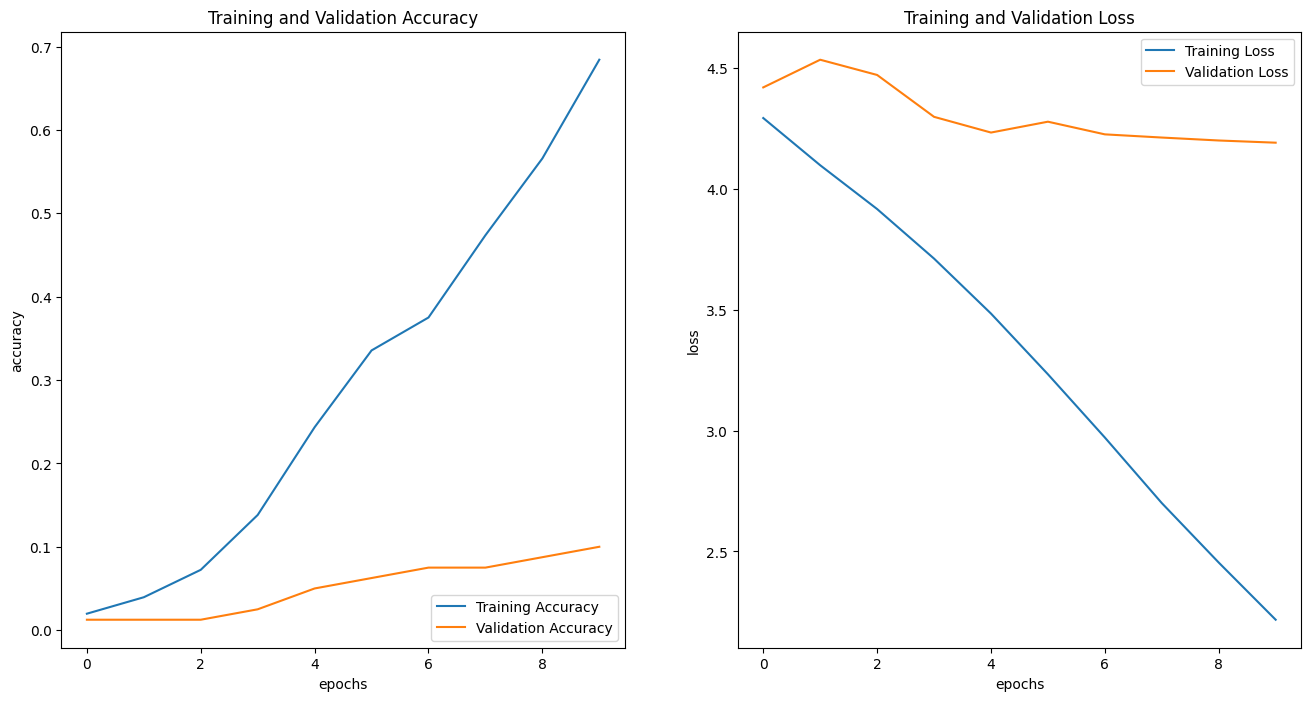

In [67]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [71]:
def define_model2(vocab_size, max_length, output_dim):
    model2 = Sequential()
    model2.add(Embedding(vocab_size,300, input_length=max_length))
    model2.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
    model2.add(MaxPooling1D(pool_size = 4))
    model2.add(Flatten())
    model2.add(Dense(32, activation='relu'))
    model2.add(Dense(output_dim, activation='softmax')) # Changed to output_dim

    model2.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

    # summarize defined model
    model2.summary()
    return model2

In [72]:
model2 = define_model2(vocab_size, max_length, output)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [73]:
history = model2.fit(X_train, y_train, epochs=15, verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.0262 - loss: 4.3773 - val_accuracy: 0.0375 - val_loss: 4.3807
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0775 - loss: 4.3344 - val_accuracy: 0.0250 - val_loss: 4.3808
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0753 - loss: 4.2929 - val_accuracy: 0.0250 - val_loss: 4.3836
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0619 - loss: 4.2083 - val_accuracy: 0.0125 - val_loss: 4.3984
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0597 - loss: 4.1164 - val_accuracy: 0.0125 - val_loss: 4.4423
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0810 - loss: 3.9877 - val_accuracy: 0.0125 - val_loss: 4.5468
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.0936 - loss: 3.7773 - val_accuracy: 0.0250 - val_loss: 4.7149
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1315 - loss: 3.7493 - val_accuracy: 0.0250 - val_loss: 4.7744

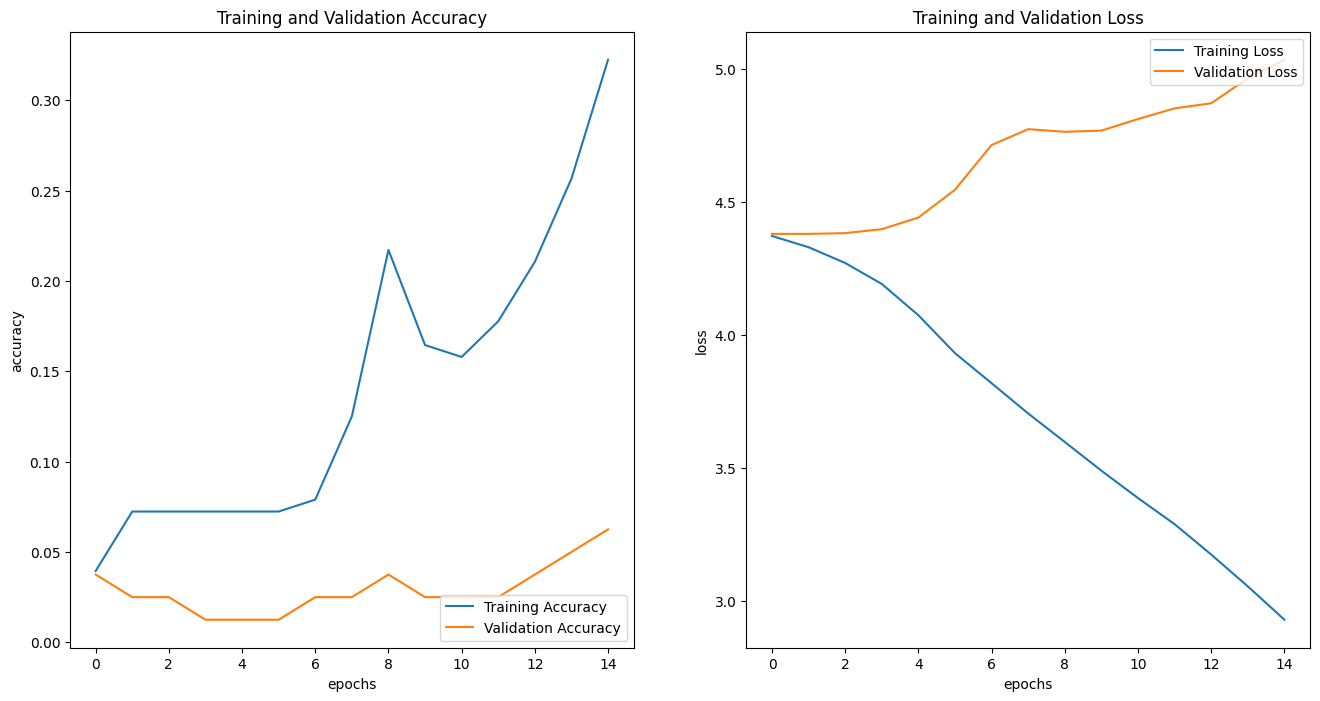

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [79]:
def define_model3(vocab_size, max_length, output_dim):
    model3 = Sequential()
    model3.add(Embedding(vocab_size,300, input_length=max_length))
    model3.add(LSTM(500))
    model3.add(Dense(output_dim, activation='softmax')) # Changed to output_dim

    model3.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    model3.summary()
    return model3

In [80]:
model3 = define_model3(vocab_size, max_length, output)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [81]:
history = model3.fit(X_train, y_train, epochs=15, verbose=1,validation_data=(X_test,y_test))

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 344ms/step - accuracy: 0.0070 - loss: 4.3449 - val_accuracy: 0.0125 - val_loss: 4.4934
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.0501 - loss: 3.8536 - val_accuracy: 0.0250 - val_loss: 4.6614
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - accuracy: 0.0657 - loss: 3.7498 - val_accuracy: 0.0125 - val_loss: 4.8924
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.0897 - loss: 3.5896 - val_accuracy: 0.0125 - val_loss: 4.8982
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.0506 - loss: 3.5411 - val_accuracy: 0.0250 - val_loss: 4.6315
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.0910 - loss: 3.4096 - val_accuracy: 0.0250 - val_loss: 4.6038
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step - accuracy: 0.1005 - loss: 3.2529 - val_accuracy: 0.0250 - val_loss: 4.7193
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.1036 - loss: 3.1647 - val_accuracy: 0.0125 - val_loss:

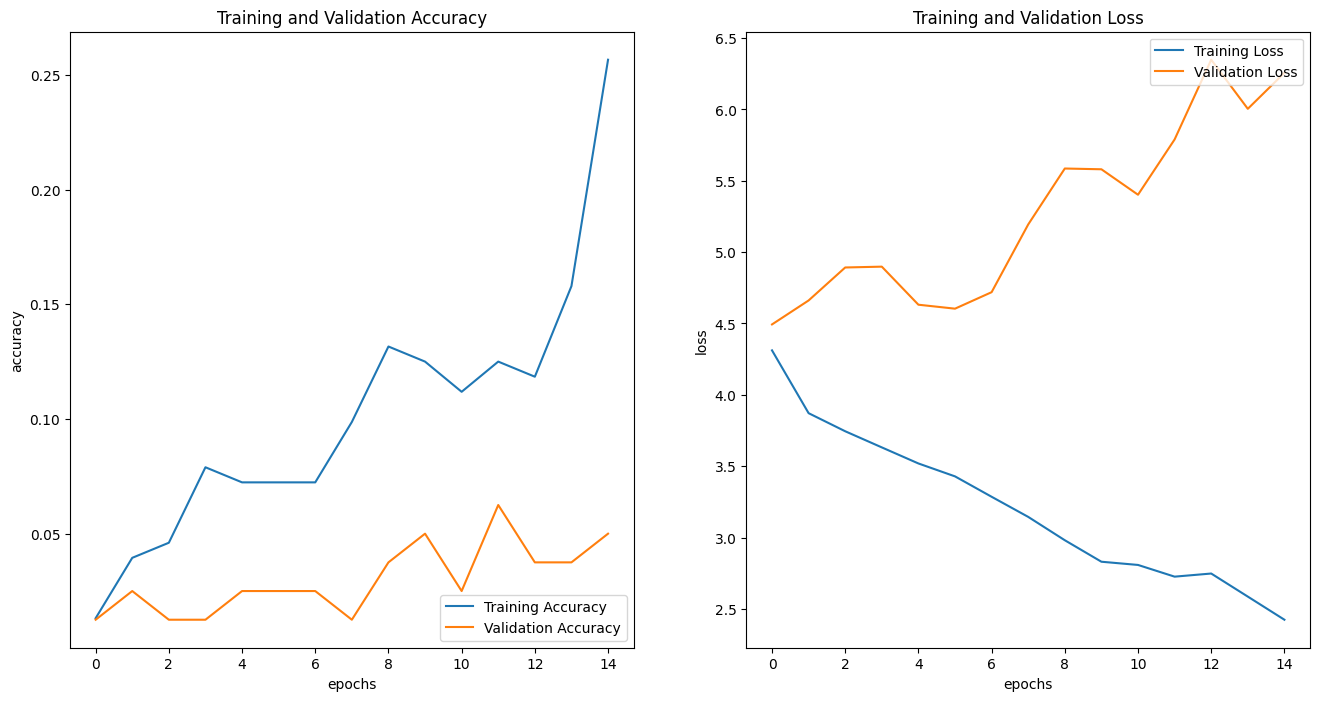

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

**CHATBOT**

In [84]:
tf.get_logger().setLevel('ERROR')
def get_text(str_text):
    # print(str_text)
    input_text  = [str_text]
    df_input = pd.DataFrame(input_text,columns=['questions'])
    df_input
    return df_input

In [85]:
model = model2
tokenizer_t = joblib.load(path_to_dumps+'tokenizer_t.pkl')
vocab = joblib.load(path_to_dumps+'vocab.pkl')

In [86]:
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
    # stop_words = set(stopwords.words('english'))
    # tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

In [87]:
def remove_stop_words_for_input(tokenizer,df,feature):
    doc_without_stopwords = []
    entry = df[feature][0]
    tokens = tokenizer(entry)
    doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return df

In [88]:
def encode_input_text(tokenizer_t,df,feature):
    t = tokenizer_t
    entry = entry = [df[feature][0]]
    encoded = t.texts_to_sequences(entry)
    padded = pad_sequences(encoded, maxlen=10, padding='post')
    return padded

In [89]:
def get_pred(model,encoded_input):
    pred = np.argmax(model.predict(encoded_input))
    return pred

In [90]:
def bot_precausion(df_input,pred):
    words = df_input.questions[0].split()
    if len([w for w in words if w in vocab])==0 :
        pred = 1
    return pred

In [91]:
def get_response(df2,pred):
    upper_bound = df2.groupby('labels').get_group(pred).shape[0]
    r = np.random.randint(0,upper_bound)
    responses = list(df2.groupby('labels').get_group(pred).response)
    return responses[r]

In [92]:
def bot_response(response,):
    print(response)

In [98]:

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib

def get_text(str_text):
    """Convert input string into a DataFrame"""
    df_input = pd.DataFrame([str_text], columns=['questions'])
    return df_input

def encode_input_text(tokenizer_t, df, feature, max_length):
    """Tokenize and pad input text to match model's expected max_length"""
    t = tokenizer_t
    entry = [df[feature][0]]
    encoded = t.texts_to_sequences(entry)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

def get_pred(model, encoded_input):
    pred = np.argmax(model.predict(encoded_input))
    return pred

def get_response(df2, pred):
    """Pick a random response for the predicted label"""
    upper_bound = df2.groupby('labels').get_group(pred).shape[0]
    r = np.random.randint(0, upper_bound)
    responses = list(df2.groupby('labels').get_group(pred).response)
    return responses[r]

def bot_response(response):
    print(response)

def start_chatbot(model, tokenizer_t, df2):
    max_length = model.input_shape[1]  # Automatically get model's expected input length
    print("Hello! I am your mental health assistant. How can I help you today?")

    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit", "bye"]:
            print("Chatbot: Take care! Bye 🤍")
            break

        df_input = get_text(user_input)
        encoded_input = encode_input_text(tokenizer_t, df_input, 'questions', max_length)

        # Predict & get response
        pred_label = get_pred(model, encoded_input)
        response = get_response(df2, pred_label)

        # Show bot response
        bot_response(response)

In [99]:
import joblib
tokenizer_t = joblib.load(path_to_dumps + 'tokenizer_t.pkl')
vocab = joblib.load(path_to_dumps + 'vocab.pkl')
model = model2
df2 = pd.read_csv('response.csv')

In [102]:
start_chatbot(model, tokenizer_t, df2)

Hello! I am your mental health assistant. How can I help you today?
You: quit
Chatbot: Take care! Bye 🤍
